root_path = '/content/drive/MyDrive/jalop/skills.txt'
import nltk
nltk.download('stopwords')
pip install cleantext
import cleantext
import codecs

file_s = codecs.open(root_path, "rU", encoding='utf-8', errors='ignore')
file_new = file_s.read()
cleans = cleantext.clean_words(file_new)

In [ ]:
from pathlib import Path
from collections import namedtuple
import pandas as pd
import numpy as np

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
data_table = pd.read_csv("/content/drive/MyDrive/jalop/testdata.csv")
new_df = data_table[['Skills', 'Software_Developer','Front_End_Developer','Network_Administrator','Web_Developer','Project_manager','Database_Administrator','Security_Analyst','Systems_Administrator','Python_Developer','Java_Developer']].copy()
new_df.head

<bound method NDFrame.head of                                                   Skills  ...  Java_Developer
0      Database Administrator;Junior DBA Database Adm...  ...               0
1      Database Administrator Database Administrator ...  ...               0
2      Database Administrator Job Seeker A Microsoft ...  ...               0
3      Database Administrator Database Administrator ...  ...               0
4      Database Administrator Database Administrator ...  ...               0
...                                                  ...  ...             ...
21988                                        Infantryman  ...               0
21989                    Lead Offsite Network Technician  ...               0
21990                      Systems/Network Administrator  ...               0
21991  Systems Administrator DDS (contractor);NETWORK...  ...               0
21992  NET/ Web Designer/Developer;Sr. Software Devel...  ...               0

[21993 rows x 11 columns]>

### labels_skills = ["Software_Developer", "Front_End_Developer", "Network_Administrator", "Web_Developer", "Project_manager", "Database_Administrator", "Security_Analyst", "Systems_Administrator", "Python_Developer", "Java_Developer"]

In [ ]:
!pip install -q transformers
!pip install pytorch_lightning

     |████████████████████████████████| 2.8 MB 13.0 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 895 kB 45.9 MB/s 
     |████████████████████████████████| 636 kB 52.4 MB/s 
     |████████████████████████████████| 3.3 MB 43.3 MB/s 
     |████████████████████████████████| 919 kB 11.1 MB/s 
     |████████████████████████████████| 829 kB 40.9 MB/s 
     |████████████████████████████████| 282 kB 50.2 MB/s 
     |████████████████████████████████| 119 kB 50.3 MB/s 
     |████████████████████████████████| 1.3 MB 51.1 MB/s 
     |████████████████████████████████| 142 kB 54.2 MB/s 
     |████████████████████████████████| 294 kB 51.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=84a411bd15e79679074a3ee69547524158156c6547fde8c992811a7755b674b8
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstal

In [ ]:
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import torch.nn as nn
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import codecs
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

In [ ]:
tokenizer12 = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (21993, 11)
TRAIN Dataset: (17594, 11)
TEST Dataset: (4399, 11)


In [ ]:
MAX_TOKEN_COUNT = 512
LABEL_COLUMNS = new_df.columns.tolist()[1:]
print(LABEL_COLUMNS)

['Software_Developer', 'Front_End_Developer', 'Network_Administrator', 'Web_Developer', 'Project_manager', 'Database_Administrator', 'Security_Analyst', 'Systems_Administrator', 'Python_Developer', 'Java_Developer']


In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

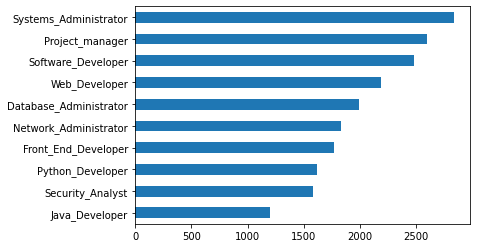

In [ ]:
train_dataset[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [ ]:
class ToxicCommentsDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.Skills
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
class ToxicCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 8
data_module = ToxicCommentDataModule(
  train_dataset,
  test_dataset,
  tokenizer12,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)


In [ ]:
BERT_MODEL_NAME = "bert-base-uncased"

In [ ]:
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps, n_warmup_steps):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss    
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
steps_per_epoch=len(train_dataset) // BATCH_SIZE

In [ ]:
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1319, 6597)

In [ ]:
model = ToxicCommentTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.to(device)

ToxicCommentTagger(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="/content/drive/MyDrive/jalop",
  filename="checkpoint.",
  save_top_k=1,
  verbose=True,
  monitor="train_loss",
  mode="min"
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content/drive/MyDrive/jalop exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [ ]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=True,
  callbacks=[checkpoint_callback],
  max_epochs=N_EPOCHS,
  progress_bar_refresh_rate=30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 7.7 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.960   Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:406: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"
/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 2199: train_loss reached 0.12278 (best 0.12278), saving model to "/content/drive/MyDrive/jalo

In [ ]:
trainer.test(model,datamodule=data_module) 

In [ ]:
##!cp '/content/drive/MyDrive/jalop/checkpoint.ckpt' berttrain


In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(checkpoint_path='/content/drive/MyDrive/jalop/checkpoint.ckpt',n_classes=10,
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device='cpu'

In [ ]:
trained_model.eval()
trained_model.freeze()
trained_model = trained_model.to(device)

In [ ]:
name_ss =""
filespath = list (name_ss)
 
filess = []
resume = Path("/content/drive/MyDrive/jalop/resume")
 
for item in resume.glob('**/*'):
  name = item.name
  filess.append(name)
 
 
resume_path = "/content/drive/MyDrive/jalop/resume"  
 
##for i in len(filess)
filelen = len(filess)
resume_number = int(input(f'files number to get results, enter in range of {filelen}'))
 
file_name_required = filess[resume_number]
file11 = codecs.open(resume_path+"/"+file_name_required, "rU", encoding='utf-8', errors='ignore')
file_new1 = file11.read()
#file_new1 to encode
 
encoding_test = tokenizer12.encode_plus(
  file_new1,
  add_special_tokens=True,
  max_length=128,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

if encoding_test["input_ids"].shape !=[1,512]:
   print(encoding_test["input_ids"].shape)


files number to get results, enter in range of 75
torch.Size([1, 1279])


In [ ]:
 _, test_prediction = trained_model(encoding_test["input_ids"].narrow(1,1,512),encoding_test["attention_mask"].narrow(1,1,512))
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

predicted_label=[]
for i,label2 in enumerate(LABEL_COLUMNS):
  label_prob = test_prediction[i]
  if label_prob>0.5:
    predicted_label.append(label2)


## Classifies a resume for specific skill/job role
print(predicted_label)   

Software_Developer: 0.017200682312250137
Front_End_Developer: 0.005841090343892574
Network_Administrator: 0.02591582201421261
Web_Developer: 0.022195659577846527
Project_manager: 0.9047873020172119
Database_Administrator: 0.03125588595867157
Security_Analyst: 0.025986313819885254
Systems_Administrator: 0.022356556728482246
Python_Developer: 0.006342812441289425
Java_Developer: 0.005260455422103405
['Project_manager']


In [ ]:
trial = codecs.open("/content/drive/MyDrive/jalop/sample 1.txt", "rU", encoding='utf-8', errors='ignore')
trial_file = trial.read()

encoding_test12 = tokenizer12.encode_plus(
  trial_file,
  add_special_tokens=True,
  max_length=128,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
print(encoding_test12["input_ids"].shape)

torch.Size([1, 281])


In [ ]:
if encoding_test12["input_ids"].shape !=[1,512]:
   print(encoding_test12["input_ids"].shape)

x_test = encoding_test12["input_ids"]
Ut_io = encoding_test["input_ids"].narrow(1,1,512)
x_main = x_test.set_(Ut_io)
y_test = encoding_test12["attention_mask"]
Ut_iot = encoding_test["input_ids"].narrow(1,1,512)
y_main = y_test.set_(Ut_iot)
y_main.shape

torch.Size([1, 281])


torch.Size([1, 512])

In [ ]:
req_label = []
req_pred = []

In [ ]:
 _, test_prediction = trained_model(x_main,y_main)
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")
  req_label.append(label)
  req_pred.append(prediction)

df_res123 = pd.DataFrame(list(zip(req_label, req_pred)),
               columns =['Label', 'Pred'])
   

predicted_label=[]
values = []
for i,label2 in enumerate(LABEL_COLUMNS):
  label_prob = test_prediction[i]
  if label_prob>0.1:
    values.append(label_prob)
    predicted_label.append(label2)

## Classifies a resume in two skill/job role
print(predicted_label)
print(values)  

Software_Developer: 0.0233861543238163
Front_End_Developer: 0.06502113491296768
Network_Administrator: 0.04258817061781883
Web_Developer: 0.12114929407835007
Project_manager: 0.03972974419593811
Database_Administrator: 0.4666747748851776
Security_Analyst: 0.022873571142554283
Systems_Administrator: 0.03369413688778877
Python_Developer: 0.017610501497983932
Java_Developer: 0.005681686569005251
['Web_Developer', 'Database_Administrator']
[0.121149294, 0.46667477]


In [ ]:
maxClm = df_res123['Pred'].max()

In [ ]:
df_res123.loc[df_res123['Pred'] == maxClm]

,Label,Pred
5,Database_Administrator,0.466675
